In [52]:
from google.colab import drive

In [53]:
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [54]:
import torch
import torchvision
import numpy as np
import pandas as pd
import PIL
import os
from pathlib import Path
import matplotlib.pyplot as plt

In [55]:
# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [56]:
augmented_images_paths = Path("/content/drive/MyDrive/Med-Vision_Project_by_Vidit_Saini_IIT_ISM_Dhanbad")
augmented_train_dir = Path("/content/drive/MyDrive/Medical_Dataset/train_augmented") #using Path funtion to get paths from drive in PosixPath format
test_dir = Path("/content/drive/MyDrive/Medical_Dataset/test")

augmented_images_paths, augmented_train_dir, test_dir

(PosixPath('/content/drive/MyDrive/Med-Vision_Project_by_Vidit_Saini_IIT_ISM_Dhanbad'),
 PosixPath('/content/drive/MyDrive/Medical_Dataset/train_augmented'),
 PosixPath('/content/drive/MyDrive/Medical_Dataset/test'))

In [57]:
try:
  from helper_functions import plot_loss_curves
except:
  print(f"could not load the helper_functions.py file, downloading")
  with open("helper_functions.py", "wb") as f:
    import requests
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/refs/heads/main/helper_functions.py")
    f.write(request.content)

Resizing and Converting the images to Tensors

In [58]:
from torchvision import datasets, transforms
import random
from PIL import Image

image_path_list = list(augmented_images_paths.glob("*/*/*.jpg"))

In [59]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

In [60]:
data_transform = transforms.Compose([
    transforms.Resize(size=(256,256)),
    transforms.Lambda(lambda img: img.convert('RGB')), # 4 channels to 3 channels
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    normalize #done to make sure, this dataset has the same image distribution as ImageNet
])

path of the image is: /content/drive/MyDrive/Med-Vision_Project_by_Vidit_Saini_IIT_ISM_Dhanbad/train_augmented/Hives Urticaria/aug_42_img(100).jpg
class of the image is: Hives Urticaria


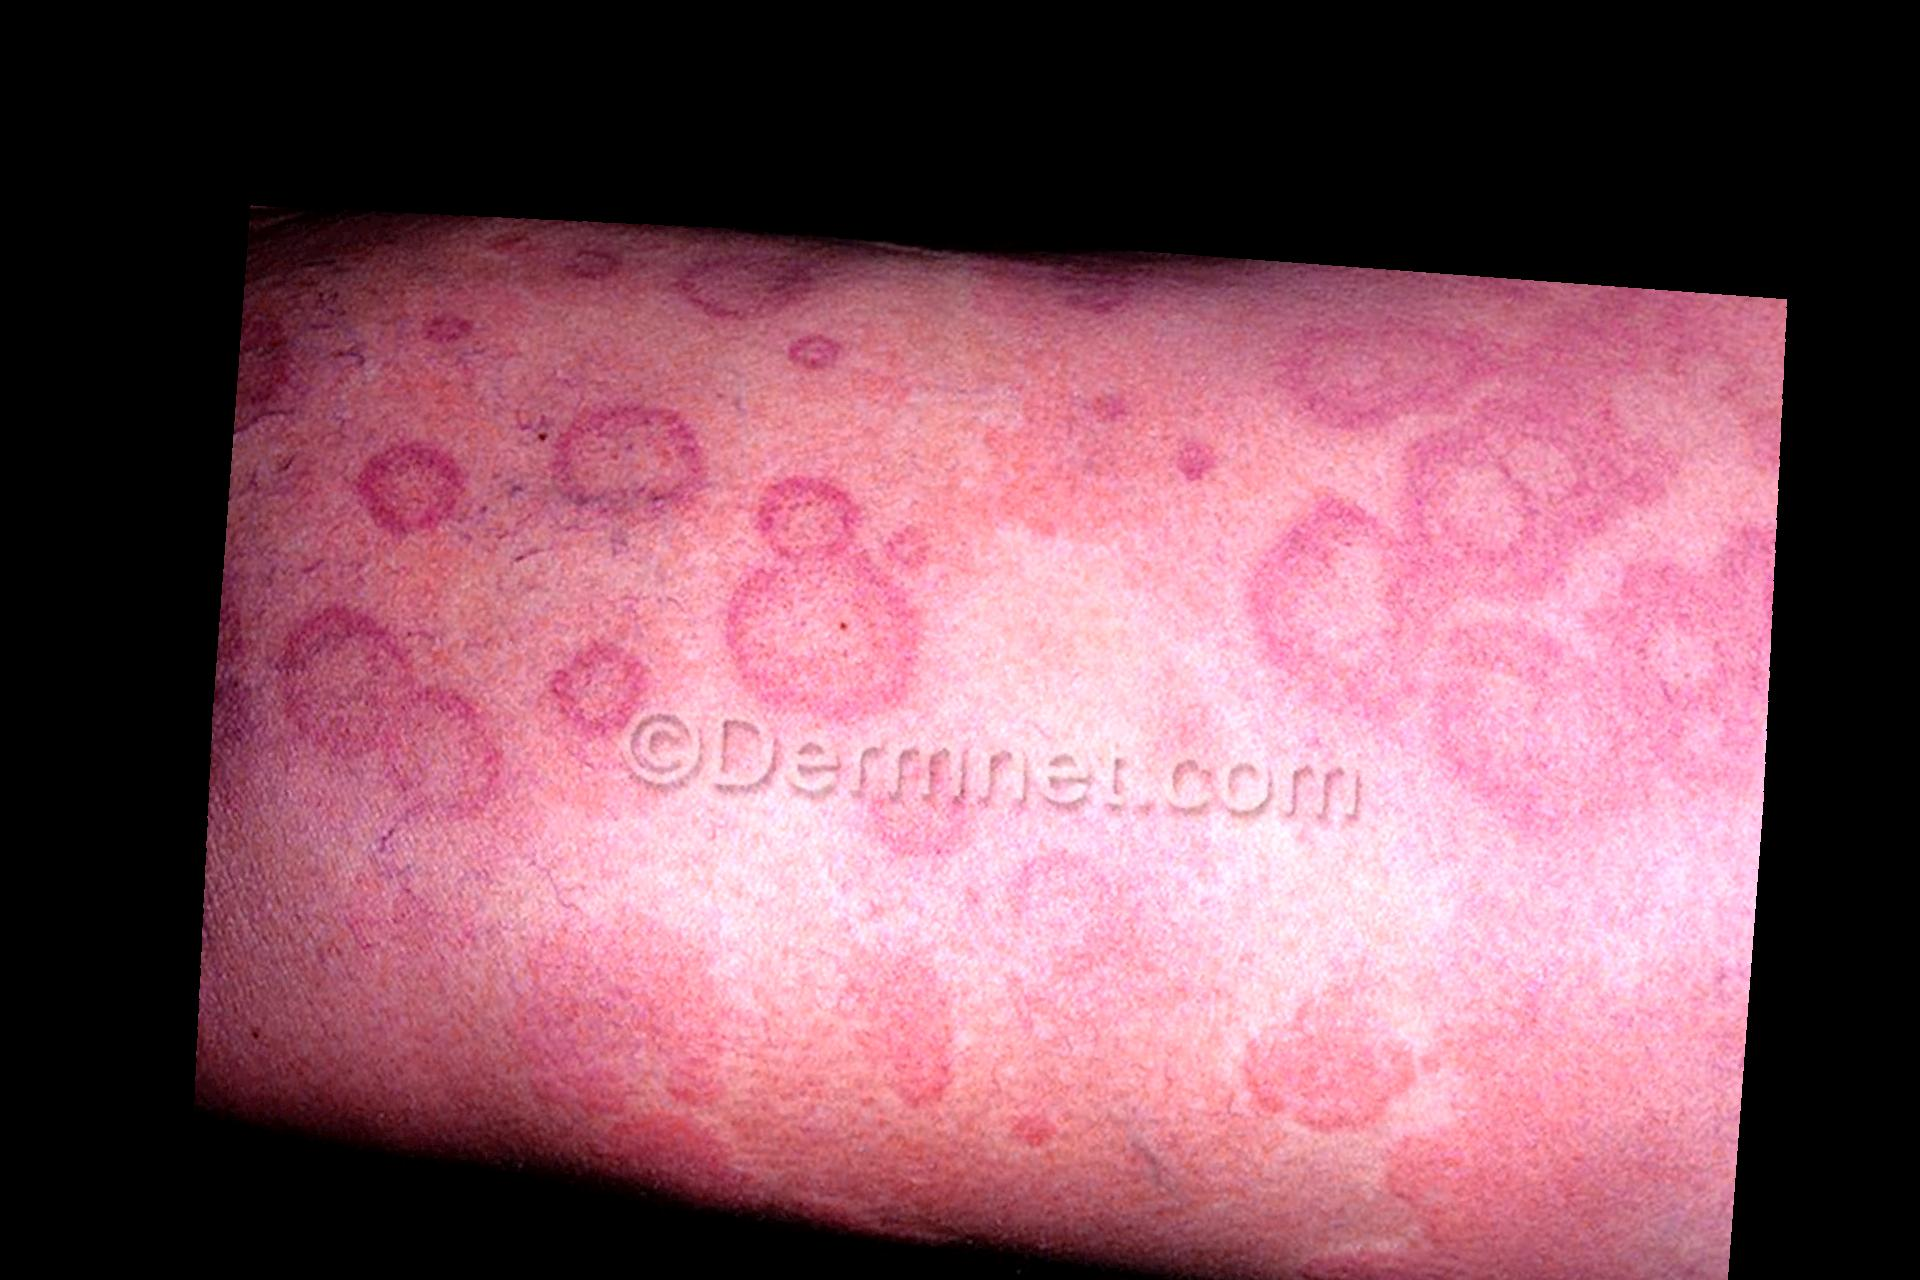

In [66]:
#picking a random image from the list and then printing it out
random_image_path = random.choice(image_path_list)

image_class = random_image_path.parent.stem

img = Image.open(random_image_path)

print(f"path of the image is: {random_image_path}")
print(f"class of the image is: {image_class}")
img

In [67]:
print(f"image tensor: {data_transform(img)}")
print(f"image shape/size: {data_transform(img).shape}")

image tensor: tensor([[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         ...,
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],

        [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         ...,
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],

        [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
         [-1.8044, -1.8044, -1.

Creating Updated datasets with augmented image folder

In [12]:
train_data = datasets.ImageFolder(root=augmented_train_dir,
                      transform=data_transform,
                      target_transform=None)

test_data = datasets.ImageFolder(root=test_dir,
                     transform=data_transform)

In [13]:
train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 12000
     Root location: /content/drive/MyDrive/Medical_Dataset/train_augmented
     StandardTransform
 Transform: Compose(
                Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=True)
                Lambda()
                RandomHorizontalFlip(p=0.5)
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ),
 Dataset ImageFolder
     Number of datapoints: 787
     Root location: /content/drive/MyDrive/Medical_Dataset/test
     StandardTransform
 Transform: Compose(
                Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=True)
                Lambda()
                RandomHorizontalFlip(p=0.5)
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ))

FROM HERE NOW IT IS CLEAR THAT THE DATASET IS NOW HAVING 12000 AUGMENTED IMAGES IN TOTAL, 1500 IMAGES FOR 8 CLASSES EACH

In [14]:
class_names = train_data.classes
classes_to_idx = train_data.class_to_idx

In [15]:
class_names, classes_to_idx

(['Acne (Normal to Mild)',
  'Conjunctivitis',
  'Folliculitis',
  'Hives Urticaria',
  'Nail Fungus and Cracked Nails',
  'Ringworms (Skin Fungal Infection)',
  'Stye (Inflammation around eyes)',
  'Warts'],
 {'Acne (Normal to Mild)': 0,
  'Conjunctivitis': 1,
  'Folliculitis': 2,
  'Hives Urticaria': 3,
  'Nail Fungus and Cracked Nails': 4,
  'Ringworms (Skin Fungal Infection)': 5,
  'Stye (Inflammation around eyes)': 6,
  'Warts': 7})

Preparing the train and test DataLoader

In [16]:
from torch.utils.data import DataLoader

In [17]:
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=32,
                              num_workers=1,
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                              batch_size=32,
                              num_workers=1,
                              shuffle=False)

In [18]:
train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7e86790b0310>,
 <torch.utils.data.dataloader.DataLoader at 0x7e867bb1e450>)

In [19]:
len(train_dataloader), len(test_dataloader), len(train_data), len(test_data)

(375, 25, 12000, 787)

In [20]:
img, label = next(iter(train_dataloader))
print(f"image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"label shape: {label.shape}")

image shape: torch.Size([32, 3, 256, 256]) -> [batch_size, color_channels, height, width]
label shape: torch.Size([32])


In [21]:
# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine

From the imported files, again creating separate dataloaders

In [22]:
from going_modular.going_modular import data_setup

#manually creating the transform

from torchvision import transforms
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

manual_transform = transforms.Compose([transforms.Resize((256,256)),
                                        transforms.ToTensor(), #to get the images in the range 0 to 1
                                        normalize]) #to make sure each image have the same distribution as ImageNet

train_dataloader_2, test_dataloader_2, class_names_2 = data_setup.create_dataloaders(train_dir=augmented_train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=manual_transform,
                                                                               batch_size=32)

EfficientNet_B0_Weights

In [23]:
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT #getting the pre-trained weights
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

In [24]:
#Getting the transforms used to create our pretrained weights
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [25]:
#Create Dataloaders using auto_transforms
train_dataloader_2, test_dataloader_2, class_names_2 = data_setup.create_dataloaders(train_dir=augmented_train_dir,
                                                                                      test_dir=test_dir,
                                                                                      transform=auto_transforms,
                                                                                      batch_size=32)
train_dataloader_2, test_dataloader_2, class_names_2

(<torch.utils.data.dataloader.DataLoader at 0x7e8678aed490>,
 ['Acne (Normal to Mild)',
  'Conjunctivitis',
  'Folliculitis',
  'Hives Urticaria',
  'Nail Fungus and Cracked Nails',
  'Ringworms (Skin Fungal Infection)',
  'Stye (Inflammation around eyes)',
  'Warts'])

It is important to note that the data which is to be passed through the pre-trained model is to be transformed wrt auto-auto_transforms. It is a must for maximum accuracy

Creating the pre-trained model now

In [26]:
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
model_v1 = torchvision.models.efficientnet_b0(weights=weights)
model_v1

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [27]:
model_v1.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

Checking out the model's Summary

In [28]:
from torchinfo import summary

summary(model=model_v1,
        input_size=(1,3,256,256),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 256, 256]     [1, 1000]            --                   True
├─Sequential (features)                                      [1, 3, 256, 256]     [1, 1280, 8, 8]      --                   True
│    └─Conv2dNormActivation (0)                              [1, 3, 256, 256]     [1, 32, 128, 128]    --                   True
│    │    └─Conv2d (0)                                       [1, 3, 256, 256]     [1, 32, 128, 128]    864                  True
│    │    └─BatchNorm2d (1)                                  [1, 32, 128, 128]    [1, 32, 128, 128]    64                   True
│    │    └─SiLU (2)                                         [1, 32, 128, 128]    [1, 32, 128, 128]    --                   --
│    └─Sequential (1)                                        [1, 32, 128, 128]    [1, 16, 128,

Freeze all the base layer to change the output shape to match the length of class

In [29]:
for param in model_v1.features.parameters():
  param.requires_grad = False

In [30]:
from torchinfo import summary

summary(model=model_v1,
        input_size=(1,3,256,256),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 256, 256]     [1, 1000]            --                   Partial
├─Sequential (features)                                      [1, 3, 256, 256]     [1, 1280, 8, 8]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 256, 256]     [1, 32, 128, 128]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 256, 256]     [1, 32, 128, 128]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 128, 128]    [1, 32, 128, 128]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 128, 128]    [1, 32, 128, 128]    --                   --
│    └─Sequential (1)                                        [1, 32, 128, 128]    [1, 1

####Setting up the correct number of Output Features

In [31]:
from torch import nn

torch.manual_seed(42)
torch.cuda.manual_seed(42)

model_v1.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True), #dropout technique is proved to be effective in regularization and preventing overfitting. Here, randomly nodes are removed/turned off, which are p=0.2, i.e 20% will be dropped
    nn.Linear(in_features=1280, # feature vector coming in
              out_features=len(class_names)).to(device) # instead of 1000 classes, we have only 8 classes
)
model_v1.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=8, bias=True)
)

###Training the model_v1

In [32]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_v1.parameters(), lr=0.001)

Training for 5 Epochs (INITIAL)

In [33]:
#Import train function
from going_modular.going_modular import engine

torch.manual_seed(42)
torch.cuda.manual_seed(42)

results_5 = engine.train(model=model_v1,
                          train_dataloader=train_dataloader_2,
                          test_dataloader=test_dataloader_2,
                          optimizer=optimizer,
                          loss_fn=loss_fn,
                          epochs=5,
                          device=device)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.8658 | train_acc: 0.7291 | test_loss: 0.5186 | test_acc: 0.8282
Epoch: 2 | train_loss: 0.5635 | train_acc: 0.8130 | test_loss: 0.4035 | test_acc: 0.8707
Epoch: 3 | train_loss: 0.4939 | train_acc: 0.8374 | test_loss: 0.3631 | test_acc: 0.8769
Epoch: 4 | train_loss: 0.4508 | train_acc: 0.8478 | test_loss: 0.3165 | test_acc: 0.8899
Epoch: 5 | train_loss: 0.4334 | train_acc: 0.8487 | test_loss: 0.3002 | test_acc: 0.8953


In [34]:
# Save the model's state_dict (weights)
torch.save(model_v1.state_dict(), 'Med_Vision_model_v1_effnet_weights_(or_state_dicts)_5E.pth')

In [35]:
# Save the entire model (architecture + weights)
torch.save(model_v1, 'Med_Vision_model_v1_effnet_full_architecture_and_weights_5E.pth')

In [36]:
# Save only the optimizer state dict
torch.save(optimizer.state_dict(), 'Med_Vision_model_v1_optimizer_state_5E.pth')

In [40]:
# Save both model weights and optimizer state_dict
torch.save({
    # 'epoch': Epoch,  # Current epoch
    'model_state_dict': model_v1.state_dict(),  # Model weights
    'optimizer_state_dict': optimizer.state_dict(),  # Optimizer state
    'loss_fn': loss_fn,  # Last loss
}, 'Med_Vision_model_with_weights_and_optimizer_5E.pth')

In [41]:
# Save a checkpoint during training
checkpoint = {
    # 'epoch': Epoch,
    'model_state_dict': model_v1.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss_fn': loss_fn
}

torch.save(checkpoint, 'checkpoint_after_5_Epochs.pth')

####Training for additional 5 Epochs (Total 10 Epochs)

In [42]:
#Import train function
from going_modular.going_modular import engine

torch.manual_seed(42)
torch.cuda.manual_seed(42)

results_10 = engine.train(model=model_v1,
                          train_dataloader=train_dataloader_2,
                          test_dataloader=test_dataloader_2,
                          optimizer=optimizer,
                          loss_fn=loss_fn,
                          epochs=5,
                          device=device)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.4085 | train_acc: 0.8632 | test_loss: 0.2883 | test_acc: 0.9007
Epoch: 2 | train_loss: 0.3969 | train_acc: 0.8635 | test_loss: 0.2727 | test_acc: 0.9015
Epoch: 3 | train_loss: 0.3829 | train_acc: 0.8697 | test_loss: 0.2680 | test_acc: 0.9053
Epoch: 4 | train_loss: 0.3669 | train_acc: 0.8741 | test_loss: 0.2480 | test_acc: 0.9103
Epoch: 5 | train_loss: 0.3683 | train_acc: 0.8705 | test_loss: 0.2489 | test_acc: 0.9124


In [44]:
# Save the model's state_dict (weights)
torch.save(model_v1.state_dict(), 'Med_Vision_model_v1_effnet_weights_(or_state_dicts)_10E.pth')

In [45]:
# Save the entire model (architecture + weights)
torch.save(model_v1, 'Med_Vision_model_v1_effnet_full_architecture_and_weights_10E.pth')

In [46]:
# Save only the optimizer state dict
torch.save(optimizer.state_dict(), 'Med_Vision_model_v1_optimizer_state_10E.pth')

In [48]:
# Save both model weights and optimizer state_dict
torch.save({
    # 'epoch': epoch,  # Current epoch
    'model_state_dict': model_v1.state_dict(),  # Model weights
    'optimizer_state_dict': optimizer.state_dict(),  # Optimizer state
    'loss_fn': loss_fn,  # Last loss
}, 'Med_Vision_model_with_weights_and_optimizer_10E.pth')

In [49]:
# Save a checkpoint during training
checkpoint = {
    # 'epoch': epoch,
    'model_state_dict': model_v1.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss_fn': loss_fn
}

torch.save(checkpoint, 'checkpoint_after_10_Epochs.pth')